# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

Import libraries used int he project:

In [11]:
import pickle
import sys
import cv2
import numpy as np
from scipy import ndimage
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.utils import shuffle

Let's define the working directory for the project info:

In [2]:
working_directory = ''

In [3]:

training_file = working_directory + 'train.p'
testing_file = working_directory + 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_raw, y_train_raw = train['features'], train['labels']
X_test_raw, y_test_raw = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [4]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train_raw.shape[0]

# TODO: Number of testing examples.
n_test = X_test_raw.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train_raw[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

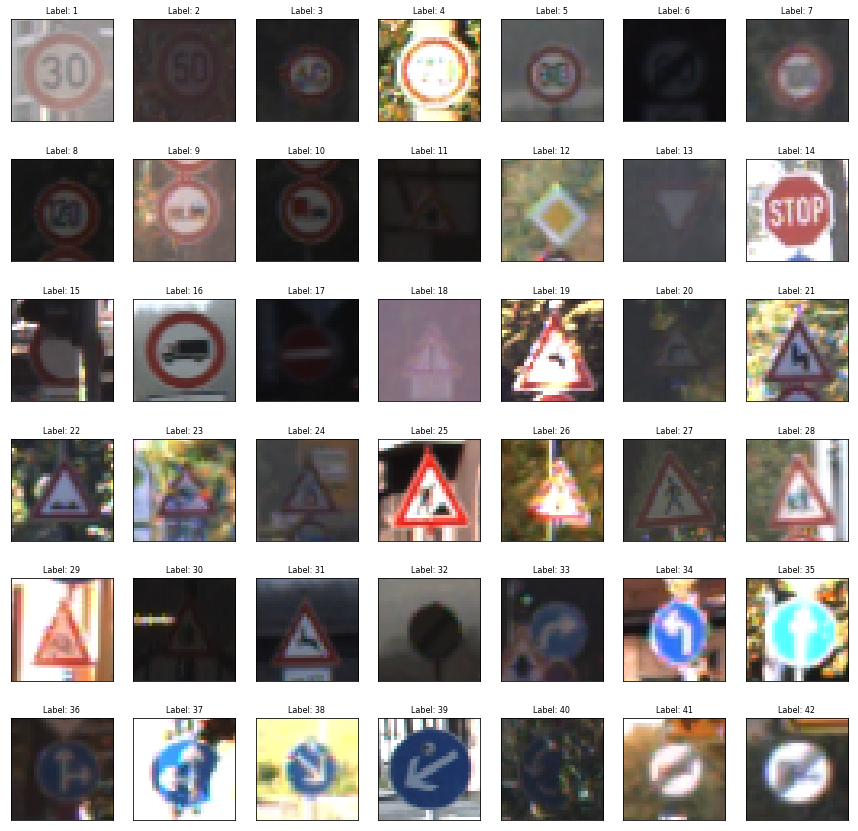

In [5]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Visualizations will be shown in the notebook.
%matplotlib inline

def get_index(labels):
    '''Returns in a python dict the position of the different label values from the labels list'''
    results = {}
    unique_values = set(labels)
    for val in unique_values:
        results[val] = [i for i,j in enumerate(labels) if j==val]
    return results

def plot_signal(train,idx,label,axis):
    '''Simply plot a sample image from dataset'''
    axis.imshow(train[idx])
    axis.set_title('Label: {0}'.format(label),fontsize=8)
    axis.set_xticks([])
    axis.set_yticks([])
    return axis

label_distributions = get_index(y_train_raw)

f, axarr = plt.subplots(6,7,figsize=(15,15))
label_id = 0
# These for loops are used to visualize all labels:
for i in range(axarr.shape[0]):
    for j in range(axarr.shape[1]):
        label_id += 1
        if label_id >= n_classes: continue
        idx = label_distributions[label_id][0] # retrieves the first label index
        axarr[i,j] = plot_signal(X_train_raw,idx,label_id,axarr[i,j])

Some signals are hard/impossible to interpret even by a human!

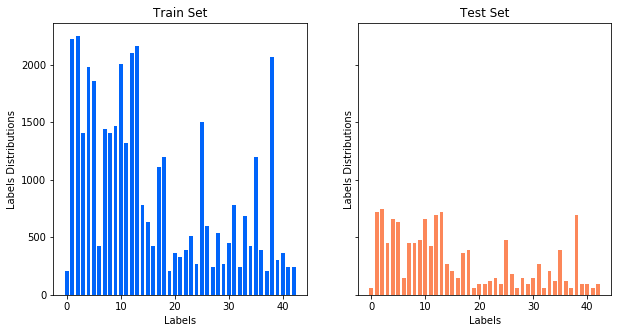

In [5]:
# Now let's visualize how labels are distributed in the train and test sets:
f, axarr = plt.subplots(1,2,figsize=(10,5),sharey=True)
colors = ['#0064FA','#FC8759']
titles = ['Train Set','Test Set']
for i,dataset_subset in enumerate([train,test]):
    label_distributions = get_index(dataset_subset['labels'])
    x = [x for x in label_distributions.keys()]
    y = [len(label_distributions[x]) for x in label_distributions.keys()]
    axarr[i].bar(x,y, 0.7, color=colors[i])
    axarr[i].set_ylabel('Labels Distributions')
    axarr[i].set_xlabel('Labels')
    axarr[i].set_title(titles[i])

WOW! the dataset is quite unbalanced!!

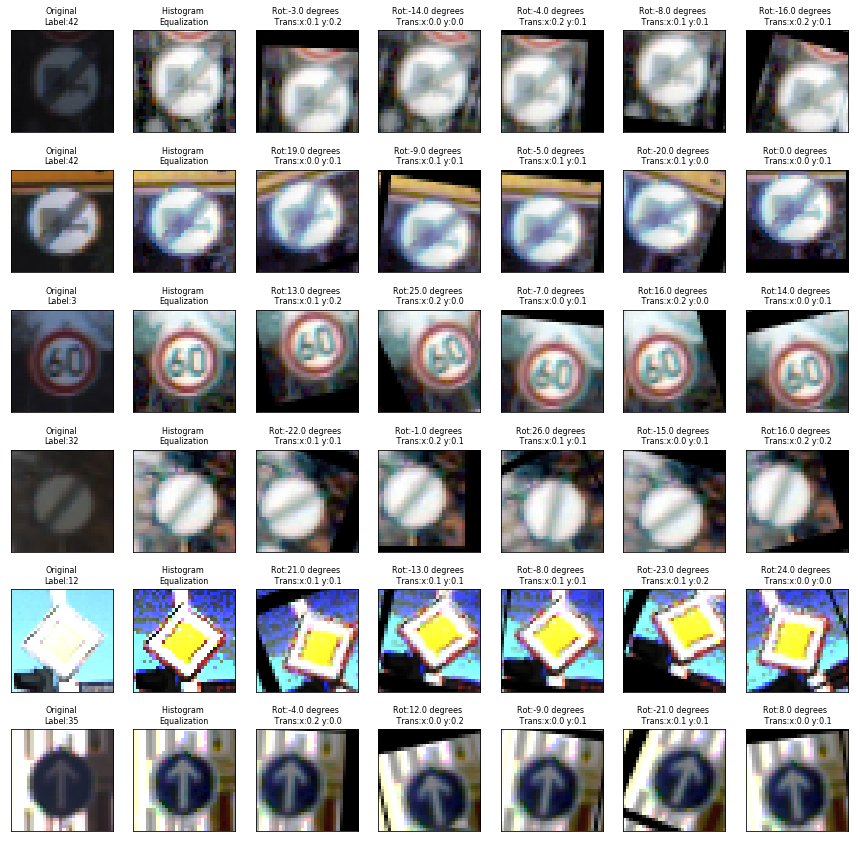

In [27]:
'''Set of functions to perform image modifications for data augmentation'''


def image_translation(img,x_percent,y_percent,random_direction = True):
    '''
    Translate images
    
    Args:
        - img: numpy array of the image
        - x_percent: value in [0-1] to translate image in X axis
        - y_percent: value in [0-1] to translate image in Y axis
        - random_direction: Direction of the translation
        
    Returns:
        - numpy array of the translated Image 
    
    '''
    rows,cols,channels = img.shape
    rows_flip = int(x_percent*rows)*np.random.choice([-1,1])
    cols_flip = int(y_percent*cols)*np.random.choice([-1,1])
    M = np.float32([[1,0,rows_flip],[0,1,cols_flip]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    return dst

def image_rotation(img,degrees):
    '''
    Rotate images
    
    Args:
        - img: numpy array of the image
        - degrees: value in [-10,+10] degrees to rotate image in X axis
        
    Returns:
        - numpy array of the translated Image 
    
    '''
    rows,cols,channels = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),degrees,1)
    dst = cv2.warpAffine(img,M,(cols,rows), borderMode=cv2.BORDER_REFLECT_101)
    return dst

def histogram_equalization(image):
    '''Improve image contrast'''
    image[:,:,0] = cv2.equalizeHist(image[:,:,0])
    image[:,:,1] = cv2.equalizeHist(image[:,:,1])
    image[:,:,2] = cv2.equalizeHist(image[:,:,2])  
    return image



# As example let's represent a particular image:
label_distributions = get_index(y_train_raw)
f, axarr = plt.subplots(6,7,figsize=(15,15))
# These for loops are used to visualize all labels:
for i in range(axarr.shape[0]):
    label_idx = np.random.choice([key for key in label_distributions.keys()])
    img_idx = np.random.choice(label_distributions[label_idx])
    img_temp = X_train_raw[img_idx]
    for j in range(axarr.shape[1]):
        if j == 0:
            axarr[i,j].imshow(img_temp)
            axarr[i,j].set_title('Original\nLabel:{}'.format(label_idx),fontsize=8)
        elif j==1:
            new_img = histogram_equalization(img_temp)
            axarr[i,j].imshow(new_img)
            axarr[i,j].set_title('Histogram \nEqualization',fontsize=8)
        else:
            x_percent,y_percent = np.random.uniform(0.0,0.2,2)
            degrees = np.random.randint(-30, +30)
            new_img = histogram_equalization(img_temp)
            new_img = image_translation(new_img,x_percent,y_percent,random_direction = True)
            new_img = image_rotation(new_img,degrees)
            axarr[i,j].imshow(new_img)
            axarr[i,j].set_title('Rot:{:3.1f} degrees \n Trans:x:{:3.1f} y:{:3.1f}'.format(degrees,x_percent,y_percent),fontsize=8)
        axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])

Let's apply contrast transformation to all pictures in the dataset:

In [7]:
## Apply contrast transformation to X_train_raw:
X_train_contrast = np.array([histogram_equalization(X_train_raw[i]) for i in range(X_train_raw.shape[0])])

In [8]:
def labels_augmentation(dataset,labels,num_pictures):
    '''This function generates as many pictures required for each label using small rotations
    to reach a total of num_pictures'''
    label_distributions = get_index(labels)
    dataset_processed = dataset
    labels_preprocessed = labels
    for label in label_distributions.keys():
        pics_available = len(label_distributions[label])
        if pics_available < num_pictures:
            pics_to_create = num_pictures - pics_available
            print ('Processing label: {0} with {2} images available, {1} images to create...'.format(label,pics_to_create,pics_available))
            for i in range(pics_to_create):
                # Use any image of the label
                label_idx = np.random.choice(label_distributions[label])
                new_img = dataset[label_idx]
                x_percent,y_percent = np.random.uniform(0.0,0.2,2)
                degrees = np.random.randint(-10, +10)
                new_img_processed = image_translation(new_img,x_percent,y_percent,random_direction = True)
                new_img_processed = image_rotation(new_img_processed,degrees)
                new_img_processed = np.expand_dims(new_img_processed, axis=0)
                # Add results
                dataset_processed = np.concatenate((dataset_processed,new_img_processed),axis=0)
                labels_preprocessed = np.append(labels_preprocessed, label)
    return dataset_processed,labels_preprocessed
                
        
#Now, let's create a balanced train and validation sets:
num_pictures_train = 1200 # number of pictures for each label in the preprocessed train set
print ("Processing Train Sets, to include {0} pictures per label.".format(num_pictures_train))
X_train_augmented, y_train_augmented = labels_augmentation(X_train_contrast,y_train_raw,num_pictures_train)



Processing Train Sets, to include 1200 pictures per label.
Processing label: 0 with 210 images available, 990 images to create...
Processing label: 6 with 420 images available, 780 images to create...
Processing label: 14 with 780 images available, 420 images to create...
Processing label: 15 with 630 images available, 570 images to create...
Processing label: 16 with 420 images available, 780 images to create...
Processing label: 17 with 1110 images available, 90 images to create...
Processing label: 19 with 210 images available, 990 images to create...
Processing label: 20 with 360 images available, 840 images to create...
Processing label: 21 with 330 images available, 870 images to create...
Processing label: 22 with 390 images available, 810 images to create...
Processing label: 23 with 510 images available, 690 images to create...
Processing label: 24 with 270 images available, 930 images to create...
Processing label: 26 with 600 images available, 600 images to create...
Process

So, how it looks now?

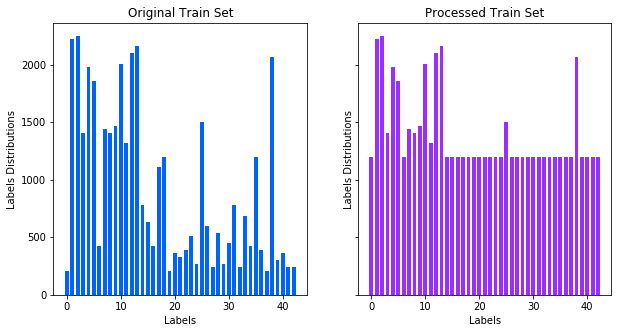

In [14]:
# Now let's visualize how labels are distributed in the preprocessed train and validation sets:
f, axarr = plt.subplots(1,2,figsize=(10,5),sharey=True,sharex=True)
colors = ['#0064FA','#9A2EFE']
titles = ['Original Train Set','Processed Train Set']
for i,dataset_subset in enumerate([y_train_raw,y_train_augmented]):
    label_distributions = get_index(dataset_subset)
    x = [x for x in label_distributions.keys()]
    y = [len(label_distributions[x]) for x in label_distributions.keys()]
    axarr[i].bar(x,y, 0.7, color=colors[i])
    axarr[i].set_ylabel('Labels Distributions')
    axarr[i].set_xlabel('Labels')
    axarr[i].set_title(titles[i])

If we remember, there was little images (less than 300 in train set) for Label = 0, now let's subset a bunch of them, now more than 1000 available to see how they look now:

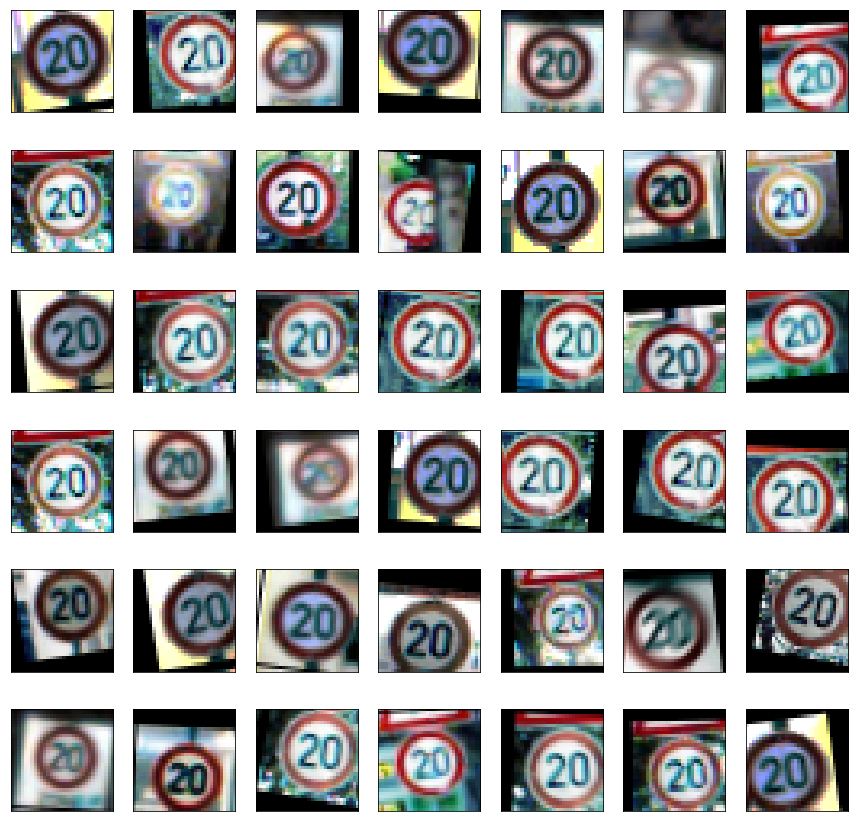

In [16]:
# As example let's represent a particular image:
label_distributions = get_index(y_train_augmented)
label = 0 # Visualize examples just for label = 0

f, axarr = plt.subplots(6,7,figsize=(15,15))
# These for loops are used to visualize all labels:
for i in range(axarr.shape[0]):
    for j in range(axarr.shape[1]):
        img_idx = np.random.choice(label_distributions[label])
        img_temp = X_train_augmented[img_idx]
        axarr[i,j].imshow(img_temp)
        axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])

To avoid repeating this process over an over, let's save results:

In [18]:
# Save processed data:
preprocessed_data = [X_train_augmented, y_train_augmented]
with open(working_directory + "preprocessed_data.pkl",'wb') as fp:
    pickle.dump(preprocessed_data,fp)

And continue working with the stored data:

In [6]:
# Load Processed data:
data = pickle.load(open(working_directory + 'preprocessed_data.pkl', 'rb'))
X_train_augmented, y_train_augmented = data

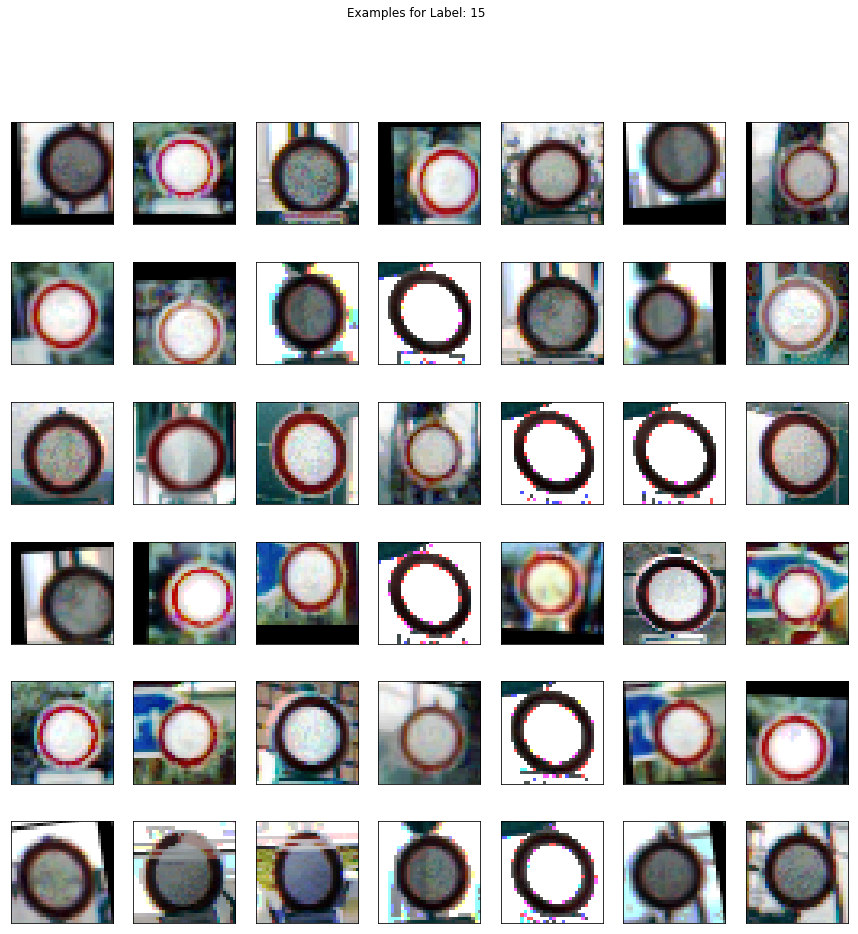

In [7]:
# As example let's represent a particular image:
label_distributions = get_index(y_train_augmented)
label = 15 # Visualize examples just for label = 0

f, axarr = plt.subplots(6,7,figsize=(15,15))
# These for loops are used to visualize all labels:
for i in range(axarr.shape[0]):
    for j in range(axarr.shape[1]):
        img_idx = np.random.choice(label_distributions[label])
        img_temp = X_train_augmented[img_idx]
        axarr[i,j].imshow(img_temp)
        axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])
f.suptitle('Examples for Label: {0}'.format(label))

Let's define a scaled function to scale all pictures for better convergation.

In [8]:
def normalization(image):
    '''MinMax Scaling'''
    normalized_image = (image - image.min()) / (image.max() - image.min())
    return normalized_image

# Normalize train set:
X_train_augmented_scaled = np.array([normalization(img) for img in X_train_augmented])


This is how pictures looks now:

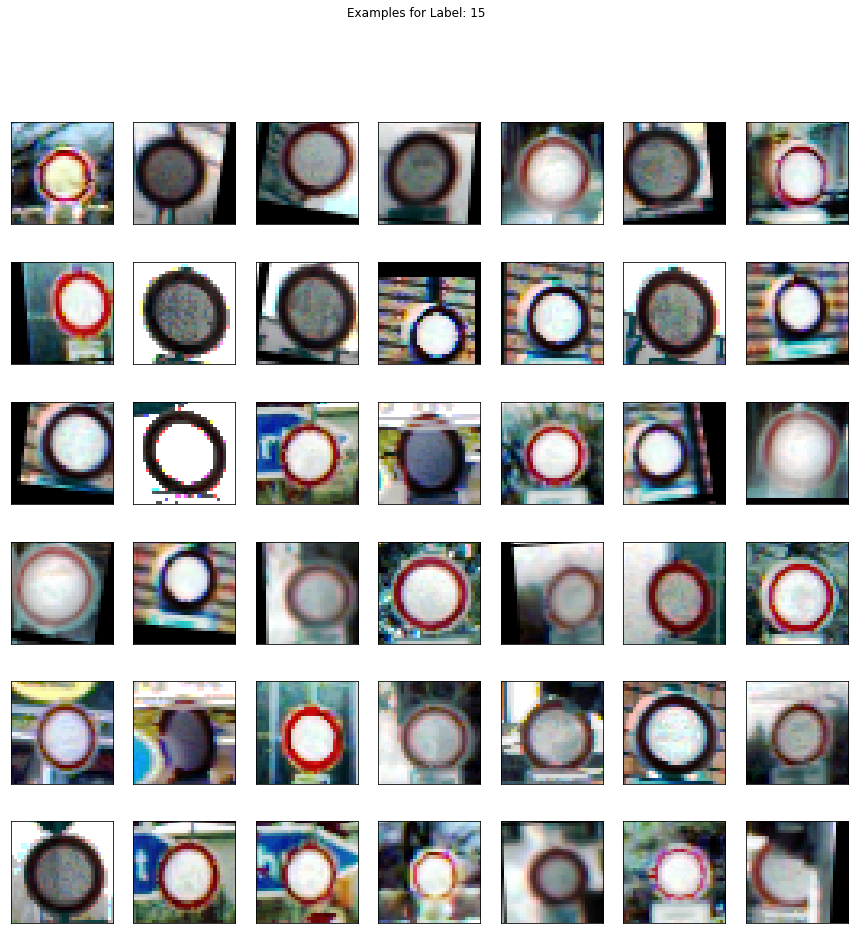

In [9]:
# As example let's represent a particular image:
label_distributions = get_index(y_train_augmented)
label = 15 # Visualize examples just for label = 0

f, axarr = plt.subplots(6,7,figsize=(15,15))
# These for loops are used to visualize all labels:
for i in range(axarr.shape[0]):
    for j in range(axarr.shape[1]):
        img_idx = np.random.choice(label_distributions[label])
        img_temp = X_train_augmented_scaled[img_idx]
        axarr[i,j].imshow(img_temp)
        axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])
f.suptitle('Examples for Label: {0}'.format(label))

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

After processing the input images, now let's create the train and validation sets to train the neural network:

In [10]:
# Let's create a train and validation sets:
X_train, X_validation, y_train, y_validation = train_test_split(X_train_augmented_scaled, y_train_augmented,stratify=y_train_augmented ,test_size=0.25, random_state=42)

In [72]:
# Now, define epoch and batch size:
EPOCHS = 20
BATCH_SIZE = 64

In [73]:
# Let's design an initial approach using LeNet arquitecture:
from tensorflow.contrib.layers import flatten

def LeNet(x,n_classes,to_gray=False,dropout=None):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    if to_gray:
        x = tf.image.rgb_to_grayscale(x, name=None)
        input_channels = 1
    else:
        input_channels = 3
        
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, input_channels, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Dropout:
    if dropout is not None: fc0 = tf.nn.dropout(fc0, dropout)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout:
    if dropout is not None: fc1 = tf.nn.dropout(fc1, dropout)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits #conv1_W,conv2_W,fc1_W,fc2_W,fc3_W,

In [74]:
# Let's create the placeholders:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32) 

In [75]:
# Training Pipeline:
rate = 0.001
dropout = 1.
logits = LeNet(x,n_classes,to_gray=False,dropout=dropout) # conv1_W,conv2_W,fc1_W,fc2_W,fc3_W,
#regularizers = (tf.nn.l2_loss(conv1_W) + tf.nn.l2_loss(conv2_W) + tf.nn.l2_loss(fc1_W) 
#                + tf.nn.l2_loss(fc2_W) + tf.nn.l2_loss(fc3_W))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)# +1e-5*regularizers
#optimizer = tf.train.AdagradOptimizer(learning_rate = rate)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [76]:
# Model Evaluation:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [77]:


train_accs = []
val_accs = []

# Training Process:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_set, y_set = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_set[offset:end], y_set[offset:end]
            if len(batch_x) != BATCH_SIZE: continue
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: dropout})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        training_accuracy = evaluate(X_train, y_train)
        
        train_accs.append(training_accuracy)
        val_accs.append(validation_accuracy)

        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet_raw')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.604

EPOCH 2 ...
Validation Accuracy = 0.771

EPOCH 3 ...
Validation Accuracy = 0.808

EPOCH 4 ...
Validation Accuracy = 0.846

EPOCH 5 ...
Validation Accuracy = 0.854

EPOCH 6 ...
Validation Accuracy = 0.881

EPOCH 7 ...
Validation Accuracy = 0.900

EPOCH 8 ...
Validation Accuracy = 0.903

EPOCH 9 ...
Validation Accuracy = 0.910

EPOCH 10 ...
Validation Accuracy = 0.913

EPOCH 11 ...
Validation Accuracy = 0.913

EPOCH 12 ...
Validation Accuracy = 0.921

EPOCH 13 ...
Validation Accuracy = 0.924

EPOCH 14 ...
Validation Accuracy = 0.923

EPOCH 15 ...
Validation Accuracy = 0.918

EPOCH 16 ...
Validation Accuracy = 0.920

EPOCH 17 ...
Validation Accuracy = 0.931

EPOCH 18 ...
Validation Accuracy = 0.923

EPOCH 19 ...
Validation Accuracy = 0.927

EPOCH 20 ...
Validation Accuracy = 0.933

Model saved


In [34]:
def plot_model_performance(train,validation):
    '''
    Visualize training results
    '''
    labels = {'train':[train,'red'],'validation':[validation,'blue']}
    for subset in labels.keys():
        data = labels[subset][0]
        plt.plot(range(1,len(data)+1), data,label=subset,color=labels[subset][1])
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend(loc='best')
    plt.title('Model Performance')

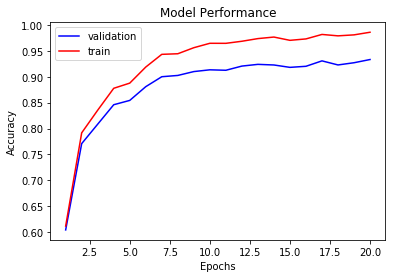

In [78]:
plot_model_performance(train_accs,val_accs)

Now, it is time to test our model over unseen data, so it is time to use the ```test``` data provided. However, it is required to process this data in the same way the training data was done:

In [42]:
# First, contrast corrections:
X_test_processed = np.array([histogram_equalization(X_test_raw[i]) for i in range(X_test_raw.shape[0])])
# And second, scaling:
X_test_processed = np.array([normalization(img) for img in X_test_processed])

In [79]:
# Evaluate the model over unseen data:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test_processed, y_test_raw)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.909


Not bad! :smile:, but let's try to do something above 0.90 :muscle:

Following table include results for different setups attempted:

|Dropout|Regularization|Learning Rate|Epcochs|Batch Size |Accuracy|
|-------|--------------|-------------|-------|-----------|--------|
|  NO   |      NO      |  0.001      |   10  |    128    |   0.89 |
|  0.7  |      NO      |  0.001      |   10  |    128    |   0.83 |
|  NO   |      YES     |  0.001      |   10  |    128    |   0.89 |
|  NO   |      NO      |  0.01       |   10  |    128    |   0.74 |
|  NO   |      NO      |  0.0001     |   10  |    128    |   0.89 |
|  NO   |      NO      |  0.001      |   20  |    64     |   0.91 |

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [ ]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.